<a href="https://colab.research.google.com/github/rambadade32/Citrurs_Disease_Detection/blob/Last_stage/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jun  2 11:54:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Sweet-Citrus-Leaf Disease Detection using CNN



In this project we're going to be using machine learning to help us identify different categories of Disease the plant have.

To do this, currently we'll be using data from the [Kaggle ](https://www.kaggle.com/dtrilsbeek/citrus-leaves-prepared) (and once our database  gets generated we'll integrate it with our this notebook.)The kaggle dataset is consists of a collection of 400+ images of
4 different citrus diseases.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify four citrus Diseases. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready , that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with subset of images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use `ImageDataGenerator`. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub. 

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

## Getting our workspace ready

### Importing the required libraries 

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
print(hub.__version__)
from keras.preprocessing.image import ImageDataGenerator

0.12.0


### Accessing data
we're accessing the data as we've already unzipped the zip file,we've :
1. train and test dataset but we don't have validation dataset.
2. Data insufficiency
3. we'll look at the image features(like size,channels)
lets make the directories to train and test data paths


In [ ]:
train_dir = "drive/MyDrive/dataset/train"
test_dir = "drive/MyDrive/dataset/test"

## Data preprocessing and Data Augumentation

In [ ]:
train_datagen=ImageDataGenerator( 
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,rescale=1./255,validation_split = 0.2,)
test_datagen = ImageDataGenerator(rescale=1./255)

### Data Splitting
usually we split our data into `Training set`,`Validation set`and`Test set`.


Here we already have trin and test sets so we'll split our training dataset into validation dataset

In [ ]:
IMG_SIZE = 224
path = "drive/MyDrive/dataset/val_set"
train_data = train_datagen.flow_from_directory(train_dir,target_size=(IMG_SIZE,IMG_SIZE),
                                               shuffle = True,
                                               seed=0,save_format ='png',
                                               subset ='training')
val_data = train_datagen.flow_from_directory(train_dir,target_size=(IMG_SIZE,IMG_SIZE),
                                             shuffle = False,
                                             subset = 'validation')


Found 380 images belonging to 4 classes.
Found 93 images belonging to 4 classes.


In [ ]:
# Preprocessed test data of perticular format and shape
test_data = test_datagen.flow_from_directory(test_dir,target_size=(IMG_SIZE,IMG_SIZE),
                                             shuffle = False,
                                             )

Found 121 images belonging to 4 classes.


In [ ]:
type(train_data.class_indices)

dict

In [ ]:
#Types of diseases 
Diseases = []

x = train_data.class_indices
for name, i in x.items():
    Diseases.append(name)

Diseases

['blackspot', 'canker', 'greening', 'healthy']

### Splitted Data Vizualization

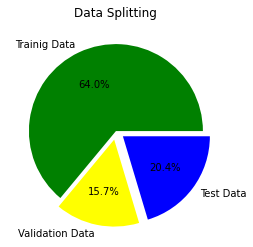

In [ ]:
val =[len(train_data.filenames),
len(val_data.filenames),
len(test_data.filenames)]

label=['Trainig Data','Validation Data','Test Data']
colours = ["green",'yellow','blue']
plt.pie(x=val,labels=label,colors=colours,explode=(0,0.1,0.1),autopct="%1.1f%%")
plt.title("Data Splitting");

### see some images in dataset


In [ ]:

from IPython.display import Image,display

def show_image(filepath):
   
   for i in range(2):
  
        im = Image("/content/drive/MyDrive/dataset/train/"+filepath[i])
     
        print(filepath[i])

        display(im)

blackspot/b (166).png


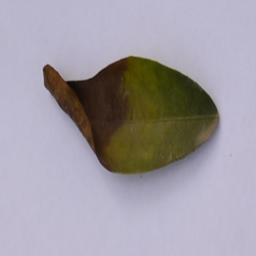

blackspot/b (167).png


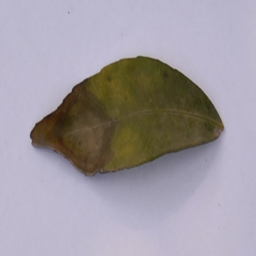

In [ ]:
show_image(train_data.filenames)

greening/g (100).png


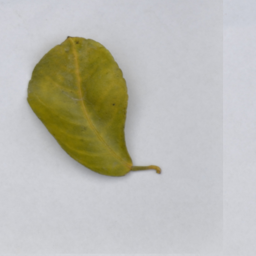

greening/g (101).png


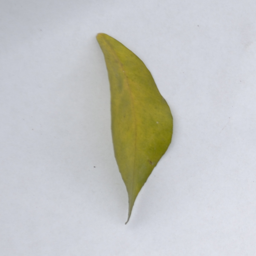

In [ ]:
show_image(val_data.filenames[54:56])

## Creating our model

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(Diseases) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
OUTPUT_SHAPE

4

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 4)                 4008      
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
In CNN, Training a model takes much time,sometimes models with Bigger datasets takes days or weeks,so while training a model we can make some callbacks like `EarlyStopping()` to stop training a model while overfitting by keeping a track on `Validation Accuracy`.

`ModelCheckpoint()` To save Best Weights for every epoch.

### Tensorboard callback

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
import os

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  """
  dir_model_log after dataset folder in drive
  """
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/final/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/final/callback',monitor='val_accuracy',verbose=0,save_best_only=True,save_weights_only=True),
    create_tensorboard_callback()
]

## Fitting Mobilenet model 
In this model training we're going to train our model on subset of our dataset by freezing the inintial hidden layers and `Imagenet` weights.

In [ ]:
# # Fit the model to the data passing it the callbacks we created
# history1= model.fit(x=train_data,
#           epochs=100,
#           validation_data=val_data,
#           validation_freq=1, # check validation metrics every epoch
#           callbacks=my_callbacks)
  

Epoch 1/100
12/12 [==============================] - 132s 8s/step - loss: 1.2751 - accuracy: 0.4632 - val_loss: 1.0227 - val_accuracy: 0.4409
Epoch 2/100
12/12 [==============================] - 6s 513ms/step - loss: 0.7473 - accuracy: 0.6474 - val_loss: 0.7487 - val_accuracy: 0.6452
Epoch 3/100
12/12 [==============================] - 6s 515ms/step - loss: 0.6074 - accuracy: 0.7658 - val_loss: 0.7419 - val_accuracy: 0.6774
Epoch 4/100
12/12 [==============================] - 6s 508ms/step - loss: 0.5630 - accuracy: 0.7526 - val_loss: 0.6561 - val_accuracy: 0.7419
Epoch 5/100
12/12 [==============================] - 6s 510ms/step - loss: 0.4831 - accuracy: 0.8132 - val_loss: 0.5792 - val_accuracy: 0.8172
Epoch 6/100
12/12 [==============================] - 6s 509ms/step - loss: 0.4713 - accuracy: 0.8158 - val_loss: 0.5038 - val_accuracy: 0.8065
Epoch 7/100
12/12 [==============================] - 6s 521ms/step - loss: 0.3967 - accuracy: 0.8526 - val_loss: 0.5513 - val_accuracy: 0.7849


## Plotting the loss-curves

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

###Loss-curves of model History1

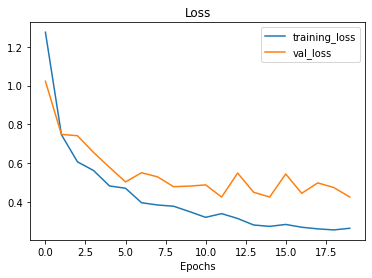

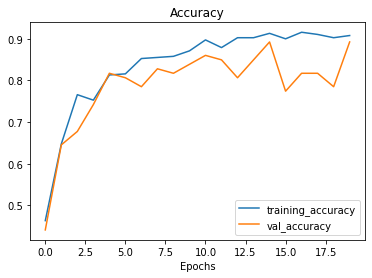

In [ ]:
# plot_loss_curves(history1)

In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 1s 382ms/step - loss: 0.4361 - accuracy: 0.8495


[0.4360918402671814, 0.8494623899459839]

In [ ]:
model.evaluate(train_data)

12/12 [==============================] - 5s 399ms/step - loss: 0.2358 - accuracy: 0.9263


[0.23577997088432312, 0.9263157844543457]

### Saving a model

In [ ]:
#function to save a model

def save_model(model,suffix=None):
  model_dir = os.path.join("drive/MyDrive/final/models",
                            datetime.datetime.now().strftime("%Y%m%D-%H%M%S"))
  model_path = model_dir + suffix +".h5"
  model.save(model_path)
  print (f"saving model at {model_path}...")
  return model_path

### Loading a model

In [ ]:
#function to load a model

def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# #Let's save our mobilenet model though we've not got an accuracy as we want...
# save_model(model,'mobilenet_final_notfinetunned')

saving model at drive/MyDrive/final/models/20210606/02/21-120500mobilenet_final_notfinetunned.h5...


'drive/MyDrive/final/models/20210606/02/21-120500mobilenet_final_notfinetunned.h5'

In [ ]:
model = load_model('drive/MyDrive/final/models/20210606/02/21-120500mobilenet_final_notfinetunned.h5')

Loading saved model from: drive/MyDrive/final/models/20210606/02/21-120500mobilenet_final_notfinetunned.h5


In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 2s 377ms/step - loss: 0.4469 - accuracy: 0.8495


[0.446859210729599, 0.8494623899459839]

In [ ]:
model.evaluate(train_data)

12/12 [==============================] - 5s 397ms/step - loss: 0.2234 - accuracy: 0.9132


[0.2233925610780716, 0.9131578803062439]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 25s 8s/step - loss: 2.2940 - accuracy: 0.4711


[2.293951988220215, 0.4710743725299835]

Though our model doing well on train and validation data but fails in testing indicates `overfitting ` so we'll fine tume our model. 

## Fine Tunning mobilenet model 
  Above we've Trained our model on`imagenet`weights so we've inintialized all the weights for each layer.
  so to improove the model accuracy we'll Unfreeze all the trainable layers and reduce the `Learning Rate` 10 times. 

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL,trainable=True), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=16,activation='relu'),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

### Recompiling our model
by Decreasing the learning rate 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:

# history2 = model.fit(train_data,validation_data=val_data,
#                    batch_size = 32,
#                    callbacks = my_callbacks,
#                    epochs = 100,)

Epoch 1/100
12/12 [==============================] - 17s 870ms/step - loss: 1.0496 - accuracy: 0.6026 - val_loss: 2.2415 - val_accuracy: 0.3011
Epoch 2/100
12/12 [==============================] - 7s 571ms/step - loss: 0.4742 - accuracy: 0.8579 - val_loss: 2.6915 - val_accuracy: 0.4516
Epoch 3/100
12/12 [==============================] - 7s 573ms/step - loss: 0.2924 - accuracy: 0.9500 - val_loss: 2.7961 - val_accuracy: 0.4301
Epoch 4/100
12/12 [==============================] - 7s 578ms/step - loss: 0.2477 - accuracy: 0.9632 - val_loss: 3.2395 - val_accuracy: 0.4086
Epoch 5/100
12/12 [==============================] - 7s 580ms/step - loss: 0.2290 - accuracy: 0.9579 - val_loss: 2.8843 - val_accuracy: 0.4624
Epoch 6/100
12/12 [==============================] - 7s 574ms/step - loss: 0.2211 - accuracy: 0.9737 - val_loss: 2.0971 - val_accuracy: 0.5484
Epoch 7/100
12/12 [==============================] - 7s 572ms/step - loss: 0.1979 - accuracy: 0.9737 - val_loss: 2.0123 - val_accuracy: 0.537

### Loss-Curves of model History 2

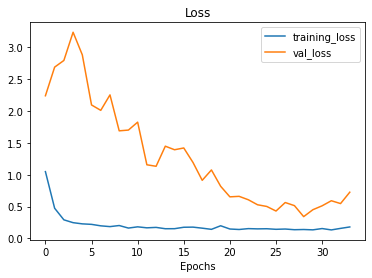

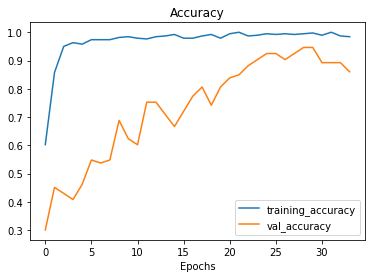

In [ ]:
# plot_loss_curves(history2)

In [ ]:
model.evaluate(val_data)

3/3 [==============================] - 1s 387ms/step - loss: 0.6051 - accuracy: 0.9032


[0.6050533056259155, 0.9032257795333862]

In [ ]:
model.evaluate(train_data)

12/12 [==============================] - 5s 401ms/step - loss: 0.1648 - accuracy: 0.9842


[0.16480523347854614, 0.9842105507850647]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 1s 136ms/step - loss: 2.1583 - accuracy: 0.4793


[2.1583378314971924, 0.4793388545513153]

In [ ]:
save_model(model,"fine_mobilenet")

saving model at drive/MyDrive/final/models/20210606/02/21-122657fine_mobilenet.h5...


'drive/MyDrive/final/models/20210606/02/21-122657fine_mobilenet.h5'

In [ ]:
model = load_model('drive/MyDrive/final/models/20210606/02/21-122657fine_mobilenet.h5')

Loading saved model from: drive/MyDrive/final/models/20210606/02/21-122657fine_mobilenet.h5


In [ ]:
model.evaluate(train_data)

12/12 [==============================] - 5s 401ms/step - loss: 0.1619 - accuracy: 0.9895


[0.16187185049057007, 0.9894737005233765]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 1s 135ms/step - loss: 2.1583 - accuracy: 0.4793


[2.1583378314971924, 0.4793388545513153]

## Predictions
  Predictions on validation data


In [ ]:
preds = model.predict(val_data)
preds[:10]

array([[9.9999988e-01, 8.7515026e-08, 2.0935850e-08, 1.3160093e-09],
       [9.9996066e-01, 1.3394509e-06, 3.7938695e-05, 4.8219565e-08],
       [9.9998033e-01, 1.7347039e-06, 1.7756252e-05, 7.2562287e-08],
       [2.6833820e-01, 4.1449104e-02, 6.8999243e-01, 2.2030581e-04],
       [1.0837863e-01, 1.6782299e-03, 8.8993979e-01, 3.4278555e-06],
       [9.9990129e-01, 1.9782841e-05, 7.8014884e-05, 8.7095987e-07],
       [9.9900901e-01, 1.2789379e-06, 9.8952791e-04, 1.1990603e-07],
       [9.8249775e-01, 5.3977624e-06, 1.7496752e-02, 1.6268443e-07],
       [9.9999523e-01, 4.9053739e-07, 4.2382799e-06, 1.0153668e-08],
       [5.8488804e-01, 1.2388797e-02, 4.0269351e-01, 2.9622963e-05]],
      dtype=float32)

In [ ]:
x=np.round(preds)
x[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# First prediction
print(preds[0])
print(f"Max value (probability of prediction): {np.max(preds[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(preds[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(preds[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {Diseases[np.argmax(preds[0])]}") # the predicted label

[9.9999988e-01 8.7515026e-08 2.0935850e-08 1.3160093e-09]
Max value (probability of prediction): 0.9999998807907104
Sum: 0.9999999403953552
Max index: 0
Predicted label: blackspot


In [ ]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return Diseases[np.argmax(prediction_probabilities)]

In [ ]:
#Actual labels of our images.


labels=[]

for i in range(len(val_data.labels)):
    labels.append(val_data.labels[i])

true_labels=[]
for i in range(len(val_data.labels)):
  true_labels.append(Diseases[labels[i]])


for i in range(2):
  print(f"{labels[i]} -- {true_labels[i]}")

0 -- blackspot
0 -- blackspot


In [ ]:
#validation Images 
val_image = []
for i in range(len(val_data.filenames)):
  val_image.append("drive/MyDrive/dataset/train/"+val_data.filenames[i])

In [ ]:
len(preds)

94

### Plotting prediction with predicted label and confirmed with true label


In [ ]:
# plotting prediction with predicted label and confirmed with true label
# of given image with image for vizualization
def plot_predictions(prediction_probabilities,labels,images,n=1):
    
    pred_probs,actual_label, real_image = prediction_probabilities[n],labels[n],images[n]

    pred_labels= get_pred_label(pred_probs)
    
    # plot image
    x = plt.imread(real_image)
    plt.imshow(x)
    plt.axis("off")

    if pred_labels == actual_label:
       color = "green"
    else:
       color = "red"   

    # give title as predictions and actual 
    plt.title("Prediction-{:.2f}-{} // Actual-{}".format(np.max(pred_probs)*100,
                                             pred_labels,
                                             actual_label),
                                             color = color)

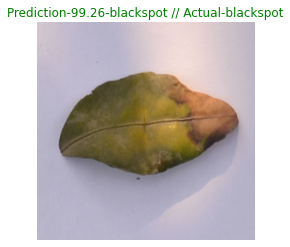

In [ ]:
plot_predictions(preds,true_labels,val_image,n=24)

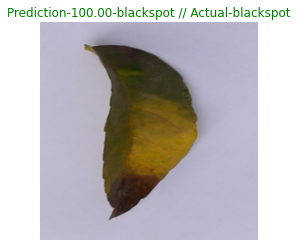

In [ ]:
plot_predictions(preds,true_labels,val_image)

In [ ]:
#plotting Probabilities of classification of each disease 
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 4 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 4 prediction confidence indexes
  top_4_pred_indexes = pred_prob.argsort()[-4:][::-1]
  
  # Find the top 4 prediction confidence values
  top_4_pred_values = pred_prob[top_4_pred_indexes]
  
  # Find the top 4 prediction labels
  top_4_pred_labels = Diseases

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_4_pred_labels)), 
                     top_4_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_4_pred_labels)),
             labels=top_4_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_4_pred_labels):
    top_plot[np.argmax(top_4_pred_labels == true_label)].set_color("green")
  else:
    pass

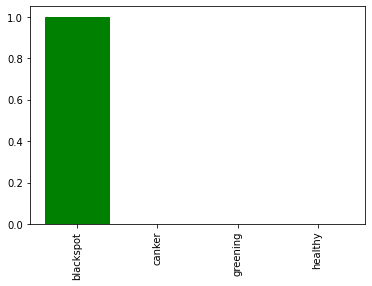

In [ ]:
plot_pred_conf(preds,true_labels)

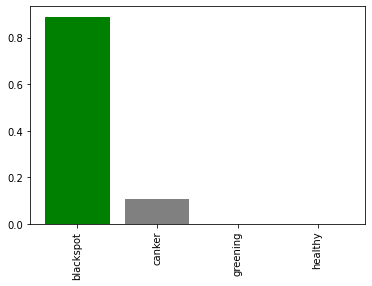

In [ ]:
plot_pred_conf(preds,true_labels,n=4)

In [ ]:
# Let's check a few predictions and their different values
def six_images(val_preds = preds):
  i_multiplier = 0
  num_rows = 3
  num_cols = 2
  num_images = num_rows*num_cols
  plt.figure(figsize=(5*2*num_cols, 5*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_predictions(prediction_probabilities=preds,
              labels=true_labels,
              images=val_image,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=preds,labels=true_labels,n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
  plt.show()

### Mob_net vizualize

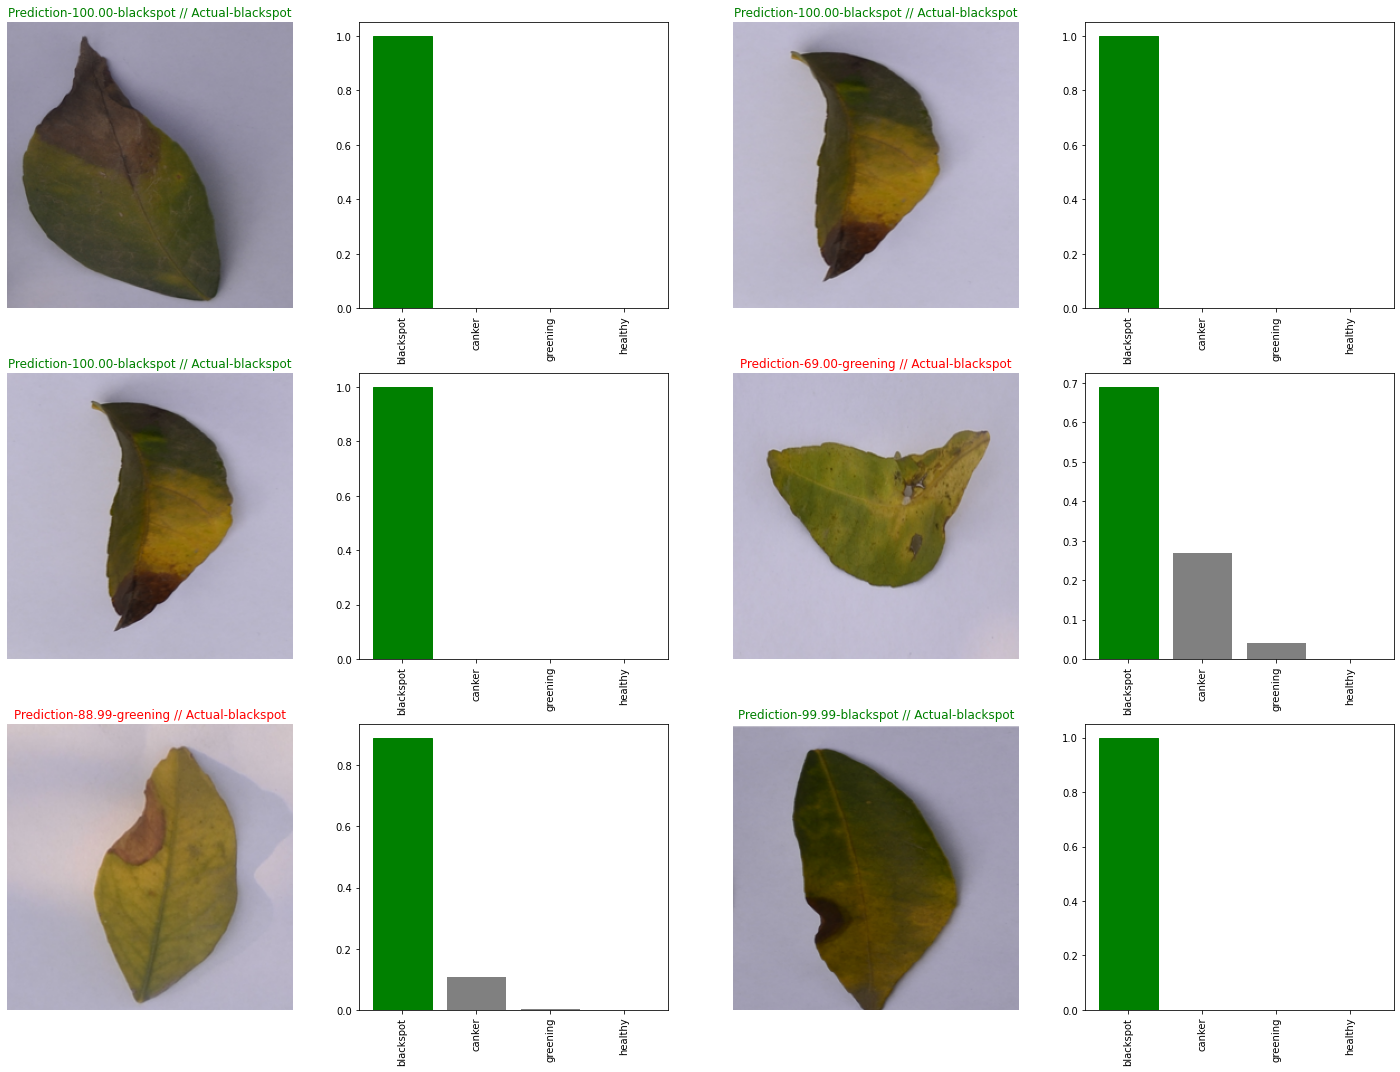

In [ ]:
six_images()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
cm=confusion_matrix(true_labels,preds)


NameError: ignored

In [ ]:
true_labels[:10]

['blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot']

In [ ]:
preds[:10]

array([[9.9999988e-01, 8.7515026e-08, 2.0935850e-08, 1.3160093e-09],
       [9.9996066e-01, 1.3394509e-06, 3.7938695e-05, 4.8219565e-08],
       [9.9998033e-01, 1.7347039e-06, 1.7756252e-05, 7.2562287e-08],
       [2.6833820e-01, 4.1449104e-02, 6.8999243e-01, 2.2030581e-04],
       [1.0837863e-01, 1.6782299e-03, 8.8993979e-01, 3.4278555e-06],
       [9.9990129e-01, 1.9782841e-05, 7.8014884e-05, 8.7095987e-07],
       [9.9900901e-01, 1.2789379e-06, 9.8952791e-04, 1.1990603e-07],
       [9.8249775e-01, 5.3977624e-06, 1.7496752e-02, 1.6268443e-07],
       [9.9999523e-01, 4.9053739e-07, 4.2382799e-06, 1.0153668e-08],
       [5.8488804e-01, 1.2388797e-02, 4.0269351e-01, 2.9622963e-05]],
      dtype=float32)

In [ ]:
y_preds = []

for i in range(len(preds)):
    x = get_pred_label(preds[i])
    y_preds.append(x)
    

In [ ]:
y_preds[:10]

['blackspot',
 'blackspot',
 'blackspot',
 'greening',
 'greening',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot',
 'blackspot']

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cfm_metrics = confusion_matrix(true_labels,y_preds)
cfm_metrics

array([[24,  0,  2,  0],
       [ 3, 23,  0,  0],
       [ 1,  0, 31,  0],
       [ 2,  0,  1,  6]])

### Confusion Matrix Plot.

Text(114.0, 0.5, 'Predicted')

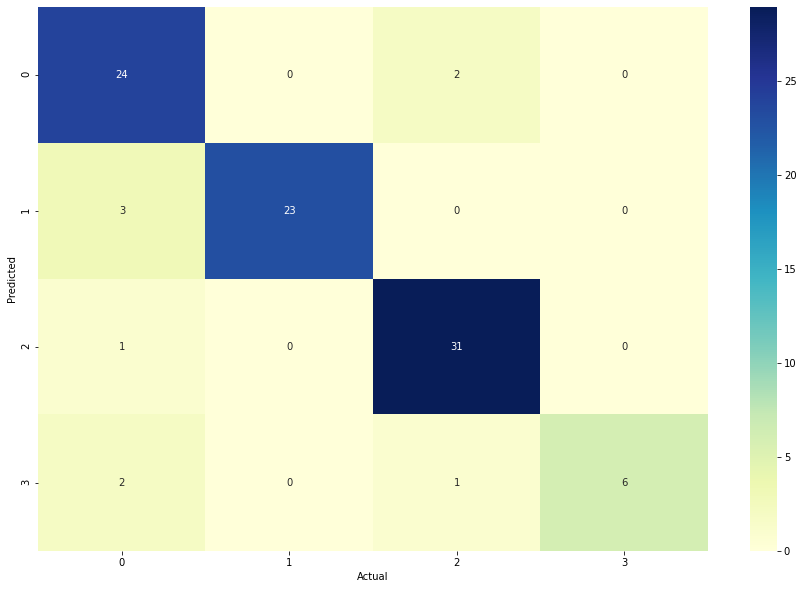

In [ ]:

## Visulization of confustion_matrics
plt.figure(figsize=(15,10))
ax=sns.heatmap(data=cfm_metrics,robust=True,cmap="YlGnBu",annot=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [IMG_SIZE,IMG_SIZE])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
dir_test ='drive/MyDrive/dataset/train/'

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(9):
  # Choose a random image from a random class 
  class_name = random.choice(Diseases)
  filename = random.choice(os.listdir(dir_test + "/" + class_name))
  filepath = dir_test + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath,scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_disease = Diseases[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_disease: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name},  pred: {pred_disease},  prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
model.evaluate(train_data)

12/12 [==============================] - 5s 405ms/step - loss: 0.1524 - accuracy: 0.9947


[0.15238848328590393, 0.9947368502616882]

### Trainig a model on full data ...

Upto Here we were trying to improove our accuracy on subset of our data (which was Training set Splitted into both training and validation.)
but now we're going to Train a model on full Training data and we'll use our test data as an validation data...

### Imagedatagenerator 
To Augment our images and to preprocess them Imagedatagenerator is better..